In [1]:
# select the data
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2
from utils import *


DIR = 'train'
DIR = 'val'
seq = 'sacre_coeur'


# Download the data
Please, uncomment and run the commands below to download the data

In [2]:
# !wget http://cmp.felk.cvut.cz/~mishkdmy/CVPR-RANSAC-Tutorial-2020/RANSAC-Tutorial-Data-EF.tar
# tar -xf  RANSAC-Tutorial-Data-EF.tar

In [3]:
#!ln -s '/home/old-ufo/papers/RANSAC_tutorial_2020/val' val

# Load the data

In [12]:
matches = load_h5(f'{DIR}/{seq}/matches.h5')
F_gt = load_h5(f'{DIR}/{seq}/Fgt.h5')
E_gt = load_h5(f'{DIR}/{seq}/Egt.h5')
matches_scores = load_h5(f'{DIR}/{seq}/match_conf.h5')
K1_K2 = load_h5(f'{DIR}/{seq}/K1_K2.h5')
R = load_h5(f'{DIR}/{seq}/R.h5')
T = load_h5(f'{DIR}/{seq}/T.h5')

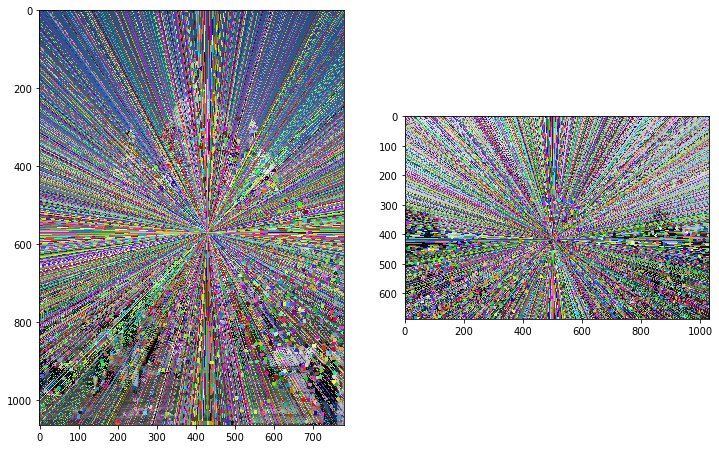

In [16]:
count = 0
pair_to_show = 0
for k, F in F_gt.items():
    if count < pair_to_show:
        count +=1
        continue
    m = matches[k]
    key_pair = k
    img1_fname = f'{DIR}/{seq}/images/' + k.split('-')[0] + '.jpg'
    img2_fname = f'{DIR}/{seq}/images/' + k.split('-')[1] + '.jpg'
    img1 = cv2.cvtColor(cv2.imread(img1_fname), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(img2_fname), cv2.COLOR_BGR2RGB)
    pts1 = m[:,:2] # coordinates in image 1
    pts2 = m[:,2:]  # coordinates in image 2
    draw_everything(img1, img2, pts1, pts2, F)
    break
    

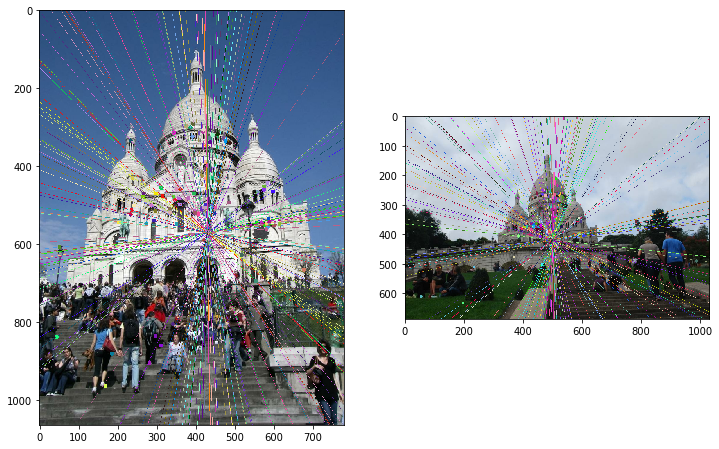

In [17]:
# Now lets draw only confident matches
k = key_pair
img_id1 = k.split('-')[0]
img_id2 = k.split('-')[1]
m = matches[k]
ms = matches_scores[k]
img1_fname = f'{DIR}/{seq}/images/' + img_id1 + '.jpg'
img2_fname = f'{DIR}/{seq}/images/' + img_id2 + '.jpg'
img1 = cv2.cvtColor(cv2.imread(img1_fname), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(img2_fname), cv2.COLOR_BGR2RGB)
good_matches = ms < 0.8
pts1 = m[good_matches, :2] # coordinates in image 1
pts2 = m[good_matches, 2:]  # coordinates in image 2
draw_everything(img1, img2, pts1, pts2, F)

    

# Toy example evaluation
Now let's estimate F with OpenCV RANSAC and evaluate its angular error

In [19]:
import cv2

F_cv, inl_mask = cv2.findFundamentalMat(pts1, pts2, cv2.RANSAC, 0.5, 0.9999)

K1 = K1_K2[img_id1 + '-' + img_id2][0][0]
K2 = K1_K2[img_id1 + '-' + img_id2][0][1]

E_cv_from_F = get_E_from_F(F_cv, K1, K2)
R1 = R[img_id1]z
R2 = R[img_id2]
T1 = T[img_id1]
T2 = T[img_id2]
dR = np.dot(R2, R1.T)
dT = T2 - np.dot(dR, T1)


p1n = normalize_keypoints(pts1, K1)
p2n = normalize_keypoints(pts2, K2)

E_cv, inl_mask = cv2.findEssentialMat(p1n, p2n, np.eye(3), cv2.RANSAC, 0.999, 1e-3)



print (max(eval_essential_matrix(p1n, p2n, E_cv_from_F, dR, dT)), 'max ang error, cv2 F, radians')
print (max(eval_essential_matrix(p1n, p2n, E_cv, dR, dT)), 'max ang error, cv2 E, radians')

print (max(eval_essential_matrix(p1n, p2n, 
                                 get_E_from_F(F_gt[img_id1 + '-' + img_id2], K1, K2), 
                                 dR, dT)),  'max ang error, E ground truth, radians')

print (max(eval_essential_matrix(p1n, p2n, 
                                 E_gt[img_id1 + '-' + img_id2], 
                                 dR, dT)), 'max ang error, E ground truth, radians')

0.01679636714370454 max ang error, cv2 F, radians
0.015568303911693983 max ang error, cv2 E, radians
1.2990531157078375e-07 max ang error, E ground truth, radians
1.2287812309317777e-07 max ang error, E ground truth, radians
